<a href="https://colab.research.google.com/github/laurelkeys/machine-learning/blob/master/assignment-3/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
COLAB = True # NOTE change me if not running on Colab :D

In [2]:
if COLAB:
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv")
    print("                                Hey!                                ")
    print("        Don't forget Google Drive's authorization code below        ")
    print("                                 ;)                                 ")
    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                                Hey!                                
        Don't forget Google Drive's authorization code below        
                                 ;)                                 
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


## Importing libs

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [5]:
if COLAB:
    try:
        # Colab only
        %tensorflow_version 2.x
    except Exception:
        pass

TensorFlow 2.x selected.


In [6]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.0.0


In [0]:
import warnings
from time import time, strftime

In [8]:
strftime('%X')

'19:55:43'

## Preparing the Fashion-MNIST dataset
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

**NOTE:** you should have the .csv files in the directory listed below

In [9]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
# confirm that you have fashion-mnist_train.csv and fashion-mnist_test.csv (unzipped)
if COLAB:
    PATH_TO_DATA = os.path.join("drive", "My Drive", "unicamp", "%ic", "mc886", "fashion-mnist-dataset")
    !ls drive/My\ Drive/unicamp/%ic/mc886/fashion-mnist-dataset/
else:
    PATH_TO_DATA = os.path.join("..", "fashion-mnist-dataset")
    !ls ../fashion-mnist-dataset/

fashion-mnist_test.csv	fashion-mnist_train.csv  README.txt


In [0]:
# the datasets have the label on the first column and the image pixels on the following 784
train_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_train.csv"), delimiter=',')
test_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_test.csv"), delimiter=',')

In [0]:
IMG_WIDTH = IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) # grayscale images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH, )

CLASS_NAME = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
CLASS_COUNT = len(CLASS_NAME)

## Split train into train + validation

In [0]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED)

In [14]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(train_dataset_csv, train_size=0.8, shuffle=True, random_state=RANDOM_SEED)
print(f"train:      {train_dataset.shape}") # 80%
print(f"validation: {validation_dataset.shape}") # 20%

test_dataset = test_dataset_csv
print(f"test:       {test_dataset.shape}")

train:      (48000, 785)
validation: (12000, 785)
test:       (10000, 785)


## Separate labels and images

In [15]:
ys_train = train_dataset["label"].values
ys_val   = validation_dataset["label"].values
ys_test  = test_dataset["label"].values

print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

(48000,) min: 0 max: 9
(12000,) min: 0 max: 9
(10000,) min: 0 max: 9


In [16]:
xs_train = train_dataset.loc[:, train_dataset.columns != "label"].values
xs_val   = validation_dataset.loc[:, validation_dataset.columns != "label"].values
xs_test  = test_dataset.loc[:, test_dataset.columns != "label"].values

print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

(48000, 784) min: 0 max: 255
(12000, 784) min: 0 max: 255
(10000, 784) min: 0 max: 255


In [0]:
def each_count(array):
    count = np.bincount(array)
    nonzero_count = np.nonzero(count)[0]
    return zip(nonzero_count, count[nonzero_count])

In [18]:
class_count_train = list(each_count(ys_train))
class_count_val   = list(each_count(ys_val))
class_count_test  = list(each_count(ys_test))
print("              Train         Validation    Test")
for label in range(CLASS_COUNT):
    print(f"{(CLASS_NAME[label] + ':'):<12}  "
          f"{class_count_train[label][1]} ({class_count_train[label][1] / ys_train.shape[0]:.2f}%)  "
          f"{class_count_val[label][1]} ({class_count_val[label][1] / ys_val.shape[0]:.2f}%)  "
          f"{class_count_test[label][1]} ({class_count_test[label][1] / ys_test.shape[0]:.2f}%)")

              Train         Validation    Test
T-shirt/top:  4863 (0.10%)  1137 (0.09%)  1000 (0.10%)
Trouser:      4795 (0.10%)  1205 (0.10%)  1000 (0.10%)
Pullover:     4817 (0.10%)  1183 (0.10%)  1000 (0.10%)
Dress:        4770 (0.10%)  1230 (0.10%)  1000 (0.10%)
Coat:         4820 (0.10%)  1180 (0.10%)  1000 (0.10%)
Sandal:       4769 (0.10%)  1231 (0.10%)  1000 (0.10%)
Shirt:        4771 (0.10%)  1229 (0.10%)  1000 (0.10%)
Sneaker:      4764 (0.10%)  1236 (0.10%)  1000 (0.10%)
Bag:          4778 (0.10%)  1222 (0.10%)  1000 (0.10%)
Ankle boot:   4853 (0.10%)  1147 (0.10%)  1000 (0.10%)


## Normalize images and one-hot encode labels

In [0]:
xs_train = xs_train.astype('float32') / 255.0
xs_val   = xs_val.astype('float32')   / 255.0
xs_test  = xs_test.astype('float32')  / 255.0

**Let's forget about the test set for now..** just assume it doesn't exist (but don't worry, we'll come back to it at the end).

In [20]:
print(f"xs_train: mean={xs_train.mean():>8.4f}, stddev={xs_train.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs_train.mean(), xs_train.std()
X_train = (xs_train - mean) / std

print(f"X_train:  mean={X_train.mean():>8.4f}, stddev={X_train.std():>7.4f}")

xs_train: mean=  0.2862, stddev= 0.3529
X_train:  mean=  0.0000, stddev= 1.0000


In [21]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean=  0.2858, stddev= 0.3526
X_val:  mean= -0.0011, stddev= 0.9992


In [0]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [23]:
Y_train = onehot_encode(ys_train)
print(ys_train.shape, Y_train.shape)

(48000,) (48000, 10)


In [24]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(12000,) (12000, 10)


_obs.:_ `Y_foo` is only a one-hot encoded version of `ys_foo` (so we use `ys_foo` in some places below, to avoid calling `np.argmax`)

## Add helper functions

In [0]:
def plot_history(history, model=None, n_epochs=None, batch_size=None, title_prefix=None):
    plot_title = ("" if title_prefix is None else (title_prefix + "\n")) + "Train history"
    info = []
    if n_epochs is not None:
        info.append(f"{n_epochs} epochs")
    if batch_size is not None:
        info.append(f"{batch_size} batch size")
    if model is not None:
        info.append(f"{model.optimizer.get_config()['name']} optimizer")
    if len(info) > 0:
        plot_title += f" ({', '.join(info)})"
    
    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "val_loss")})
    loss_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss" + f" ({model.loss})" if model is not None else "")
    plt.show()

    # leave only "accuracy" and "val_accuracy" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "accuracy" or k == "val_accuracy")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

In [0]:
def plot_image_with_prediction(xs, ys, ys_pred, num_rows=5, num_cols=3):
    # ref.: https://www.tensorflow.org/tutorials/keras/classification
    
    def plot_image(i, predictions_array, true_label, img):
        true_label, img = true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img.reshape(IMG_SHAPE), cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions_array)
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAME[predicted_label],
                                             100*np.max(predictions_array),
                                             CLASS_NAME[true_label]),
                                             color=color)

    def plot_value_array(i, predictions_array, true_label):
        true_label = true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')
    
    # plot the first few test images, their predicted labels, and the true labels
    # color correct predictions in blue and incorrect predictions in red    
    num_images = num_rows * num_cols
    plt.figure(figsize=(4 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(i, ys_pred[i], ys, xs)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i, ys_pred[i], ys)
    plt.tight_layout()
    plt.show()

In [0]:
from sklearn.metrics import confusion_matrix, f1_score

In [0]:
def print_cm(ys, ys_pred, class_names, figsize=(10, 9), fontsize=12):
    #cm = confusion_matrix(ys, ys_pred)
    #df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm = np.flip(confusion_matrix(ys, ys_pred), axis=0)
    df_cm = pd.DataFrame(cm, index=class_names[::-1], columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylim(*heatmap.get_xlim())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 1. Baseline
Explore Neural Networks with Fashion-MNIST. What is the accuracy? Describe your Neural Network architecture.

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.regularizers import l1, l2

In [0]:
MAX_EPOCHS = 64
BATCH_SIZE = 512
TF_VERBOSE = 1 # 0 = silent, 1 = progress bar, 2 = one line per epoch

In [0]:
def train(model, X_train, Y_train, X_val, Y_val, n_epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, 
          min_delta=0.003, patience=3, early_stopping=True, plot_title=None, plot=True):
    best_model_path = os.path.join("models", f"best_model_{model.name}.h5")
    if not os.path.exists(os.path.dirname(best_model_path)):
        os.makedirs(os.path.dirname(best_model_path))
    
    callbacks = ([keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True)]
                 if not early_stopping else
                 [keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True),
                  keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience)])
    
    print("Starting to train...")
    start = time()
    hist = model.fit(
        x=X_train, y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=TF_VERBOSE
    ).history
    end = time()
    print(f"\nDone.\nTraining took {(end - start):.2f}s")
    
    if os.path.exists(best_model_path):
        model = keras.models.load_model(best_model_path)
    
    if plot:
        plot_history(hist, model, n_epochs, batch_size, plot_title)
    
    return hist, model

### 1.1. MLP

In [0]:
model = keras.Sequential([
    Input(IMG_FLAT_SHAPE), # 28 * 28 = 784 pixels
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "MLP_baseline")

In [0]:
# NOTE use 'categorical_crossentropy' since `labels` is a one-hot encoded vector
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "MLP_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

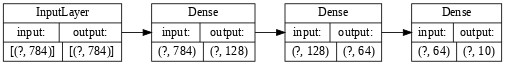

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

In [37]:
strftime('%X')

'19:56:22'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 2s 49us/sample - loss: 0.6592 - accuracy: 0.7704 - val_loss: 0.4753 - val_accuracy: 0.8344
Epoch 2/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.4248 - accuracy: 0.8523 - val_loss: 0.4071 - val_accuracy: 0.8593
Epoch 3/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3843 - accuracy: 0.8650 - val_loss: 0.4013 - val_accuracy: 0.8602
Epoch 4/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3562 - accuracy: 0.8749 - val_loss: 0.3623 - val_accuracy: 0.8734
Epoch 5/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3311 - accuracy: 0.8837 - val_loss: 0.3593 - val_accuracy: 0.8736
Epoch 6/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3153 - accuracy: 0.8907 - val_loss: 0.3463 - val_accuracy: 0.8765
Epoch 7/64
48000/48000 [===========

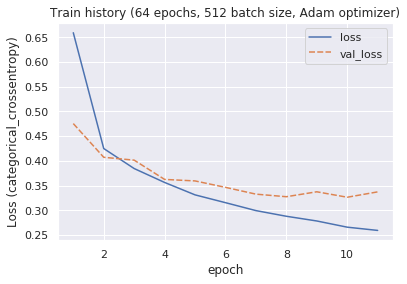

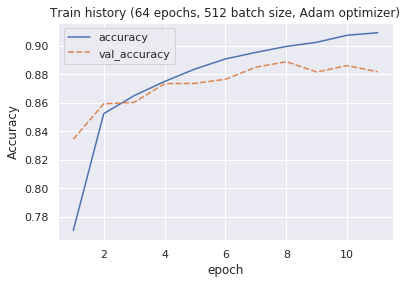

In [38]:
history, best_model = train(model, X_train, Y_train, X_val, Y_val)

In [39]:
strftime('%X')

'19:56:32'

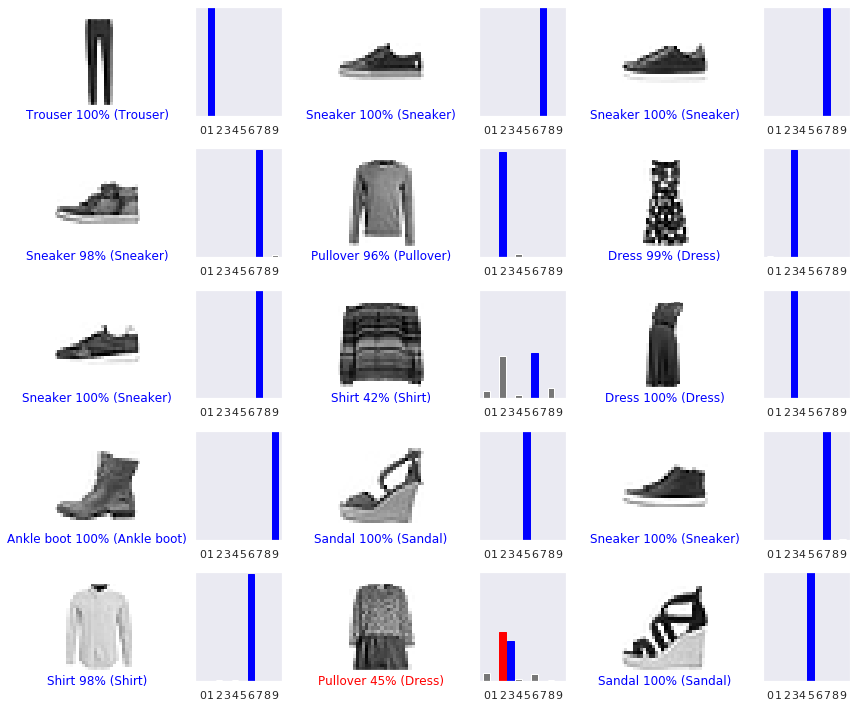

In [40]:
Y_val_pred = best_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_pred)

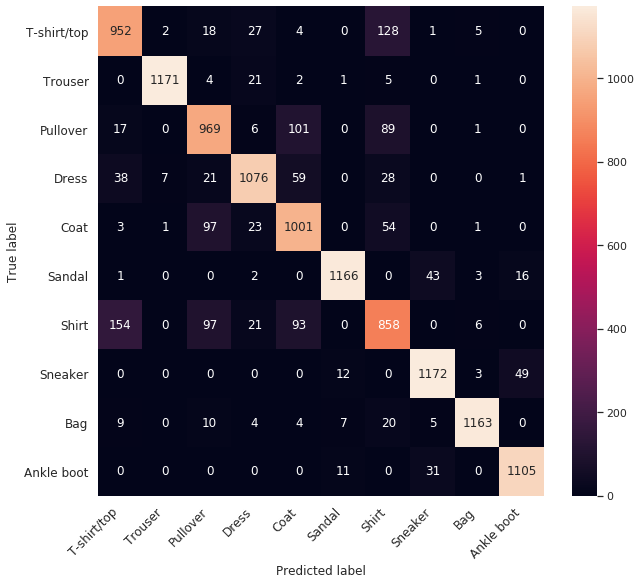

In [41]:
print_cm(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

### 1.2. CNN

In [0]:
# obs.: padding='valid' by default (i.e. no padding)
conv_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_baseline")

In [0]:
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [44]:
conv_model.summary()

Model: "CNN_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [45]:
conv_model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

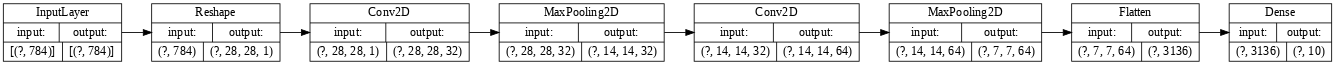

In [46]:
tf.keras.utils.plot_model(conv_model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

In [47]:
strftime('%X')

'19:56:38'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 6s 123us/sample - loss: 0.7290 - accuracy: 0.7595 - val_loss: 0.5056 - val_accuracy: 0.8278
Epoch 2/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.4294 - accuracy: 0.8556 - val_loss: 0.4025 - val_accuracy: 0.8683
Epoch 3/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.3768 - accuracy: 0.8763 - val_loss: 0.3666 - val_accuracy: 0.8832
Epoch 4/64
48000/48000 [==============================] - 2s 49us/sample - loss: 0.3550 - accuracy: 0.8835 - val_loss: 0.3618 - val_accuracy: 0.8795
Epoch 5/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.3273 - accuracy: 0.8932 - val_loss: 0.3321 - val_accuracy: 0.8917
Epoch 6/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.3174 - accuracy: 0.8968 - val_loss: 0.3199 - val_accuracy: 0.8982
Epoch 7/64
48000/48000 [==========

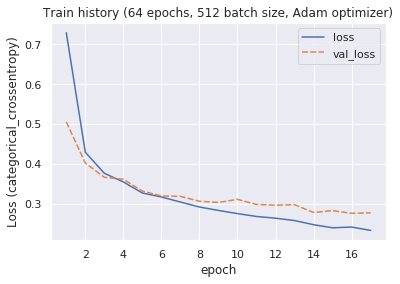

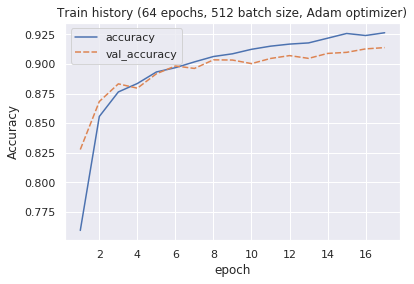

In [48]:
conv_history, best_conv_model = train(conv_model, X_train, Y_train, X_val, Y_val)

In [49]:
strftime('%X')

'19:57:24'

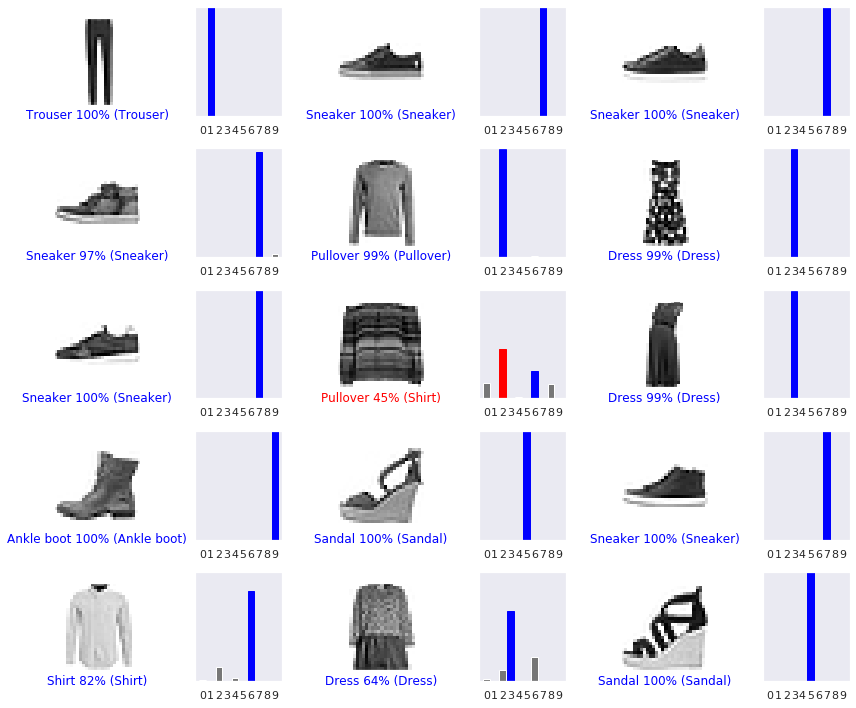

In [50]:
Y_val_conv_pred = best_conv_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_pred)

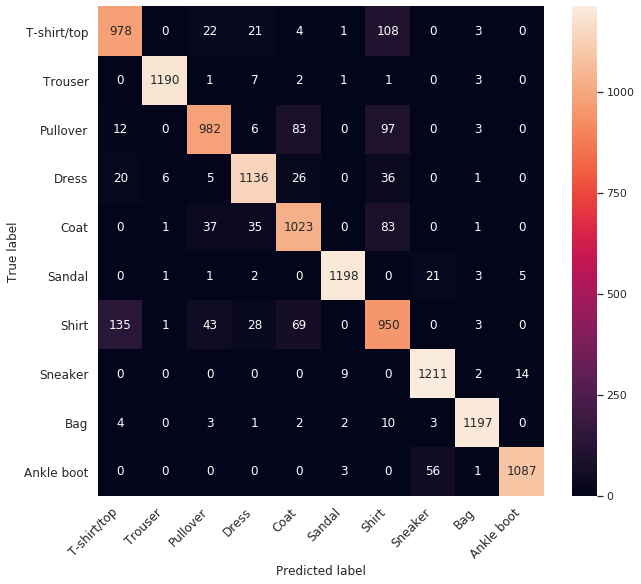

In [51]:
print_cm(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

## 2. Using PCA
Re-do the ﬁrst experiment considering the PCA dimensionality reduction. Consider three diﬀerent energies (variance) for reducing the image dimensionality. What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [0]:
from sklearn.decomposition import PCA

In [0]:
def print_info(array, name):
    print(f"{name+':':<9} {array.dtype.name:<7} {str(array.shape):<12} "
          f"| min: {array.min():>5.2f} | max: {array.max():>5.2f} "
          f"| mean: {array.mean():>5.3f} | std: {array.std():>5.3f}")

In [54]:
print_info(X_train, "X_train")
print_info(xs_train, "xs_train")
print_info(Y_train, "Y_train")
print_info(ys_train, "ys_train")

X_train:  float32 (48000, 784) | min: -0.81 | max:  2.02 | mean: 0.000 | std: 1.000
xs_train: float32 (48000, 784) | min:  0.00 | max:  1.00 | mean: 0.286 | std: 0.353
Y_train:  float64 (48000, 10)  | min:  0.00 | max:  1.00 | mean: 0.100 | std: 0.300
ys_train: int64   (48000,)     | min:  0.00 | max:  9.00 | mean: 4.495 | std: 2.879


_As we'll be reducing the amount of features (dimensions) of our input data after applying PCA, it makes more sense to treat it as a vector, instead of as an image.
Thus, we'll use our MLP baseline model instead of our CNN, even though the latter showed better results._

In [0]:
def build_pca_model(min_explained_variance, model_name):
    pca = PCA(min_explained_variance)
    pca.fit(X_train) # fit on train data (and then use it to transform both train and validation)
    print(pca)
    print()
    
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"{pca.n_components_} principal components → {explained_variance} explained variance")
    print(f"{pca.n_components_} / {X_train.shape[1]} = {(100 * pca.n_components_ / X_train.shape[1]):.2f}% of components used")
    
    model_pca = keras.Sequential([
        Input(shape=(pca.n_components_, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)
    
    model_pca.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model_pca, pca

In [0]:
def train_pca_model(model_pca, pca):
    history_pca, best_model_pca = train(model_pca, 
                                        pca.transform(X_train), Y_train, 
                                        pca.transform(X_val), Y_val, 
                                        n_epochs=64, batch_size=512)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_pca_pred = best_model_pca.predict(pca.transform(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_pca_pred)

    print_cm(ys_val, np.argmax(Y_val_pca_pred, axis=1), CLASS_NAME)
    
    return Y_val_pca_pred

### 2.1. 99% explained variance

In [57]:
model_99var, pca_99var = build_pca_model(min_explained_variance=0.99, model_name="MLP_99var")

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

458 principal components → 0.9900491237640381 explained variance
458 / 784 = 58.42% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 24us/sample - loss: 0.7713 - accuracy: 0.7551 - val_loss: 0.4376 - val_accuracy: 0.8528
Epoch 2/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3865 - accuracy: 0.8706 - val_loss: 0.3837 - val_accuracy: 0.8674
Epoch 3/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3308 - accuracy: 0.8897 - val_loss: 0.3683 - val_accuracy: 0.8733
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2959 - accuracy: 0.9017 - val_loss: 0.3552 - val_accuracy: 0.8792
Epoch 5/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.2690 - accuracy: 0.9124 - val_loss: 0.3509 - val_accuracy: 0.8808
Epoch 6/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2446 - accuracy: 0.9224 - val_loss: 0.3411 - val_accuracy: 0.8823
Epoch 7/64
48000/48000 [===========

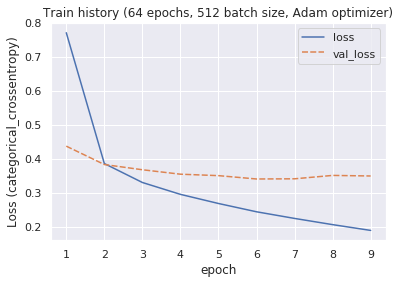

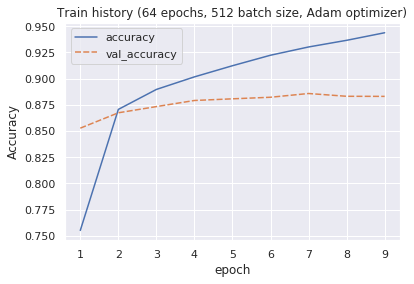

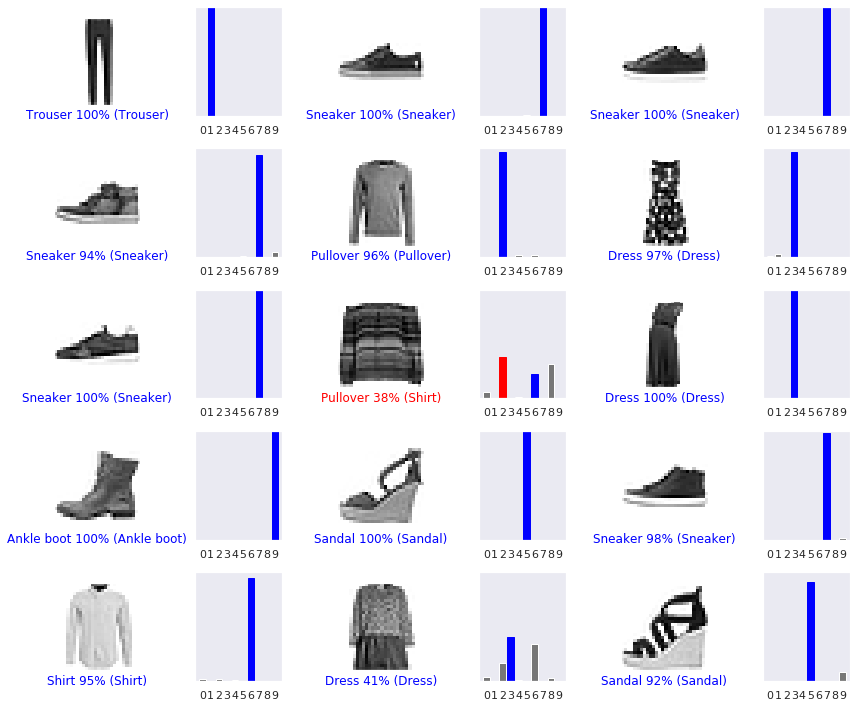

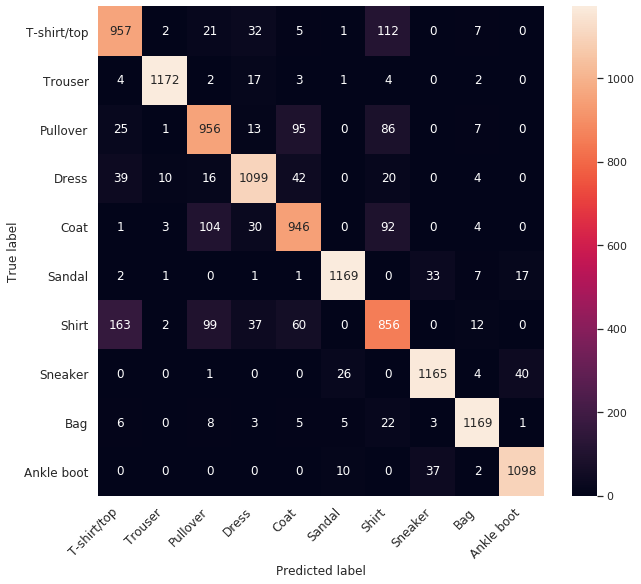

In [58]:
Y_val_99var_pred = train_pca_model(model_99var, pca_99var)

### 2.2. 95% explained variance

In [59]:
model_95var, pca_95var = build_pca_model(min_explained_variance=0.95, model_name="MLP_95var")

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

187 principal components → 0.9501577615737915 explained variance
187 / 784 = 23.85% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 23us/sample - loss: 0.8532 - accuracy: 0.7277 - val_loss: 0.4649 - val_accuracy: 0.8471
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4188 - accuracy: 0.8586 - val_loss: 0.3977 - val_accuracy: 0.8675
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3647 - accuracy: 0.8772 - val_loss: 0.3712 - val_accuracy: 0.8749
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3341 - accuracy: 0.8871 - val_loss: 0.3541 - val_accuracy: 0.8807
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3108 - accuracy: 0.8957 - val_loss: 0.3442 - val_accuracy: 0.8816
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.2928 - accuracy: 0.9017 - val_loss: 0.3421 - val_accuracy: 0.8842
Epoch 7/64
48000/48000 [===========

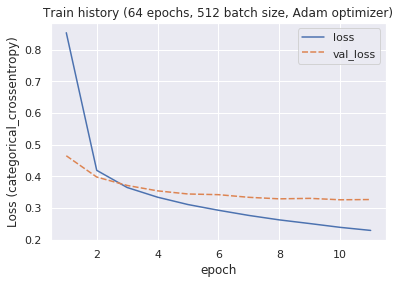

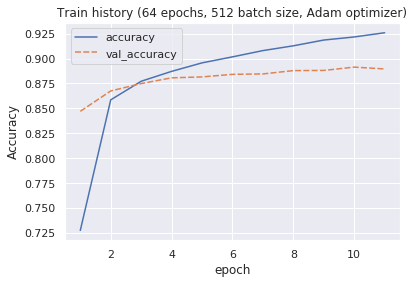

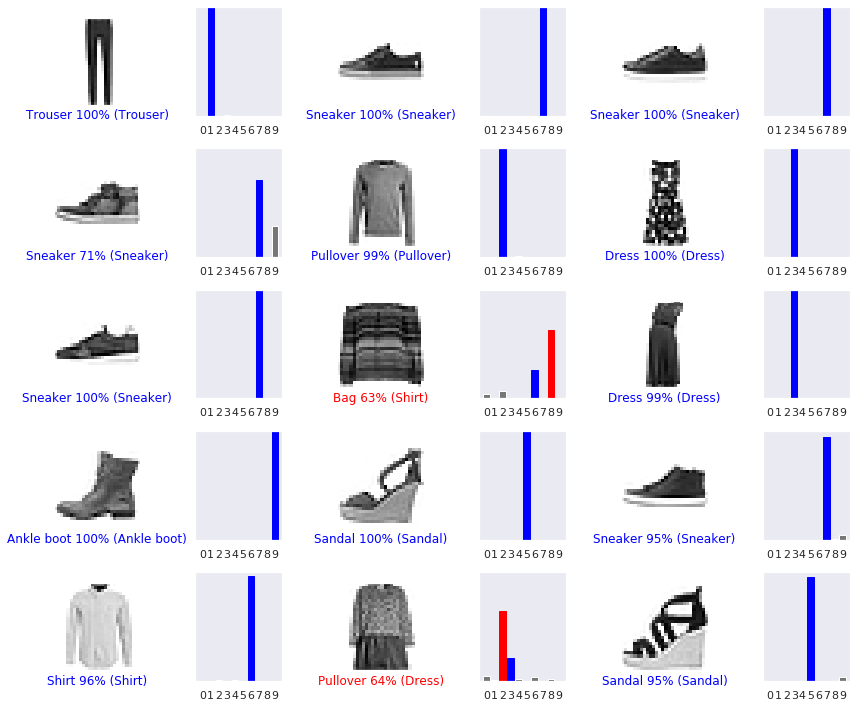

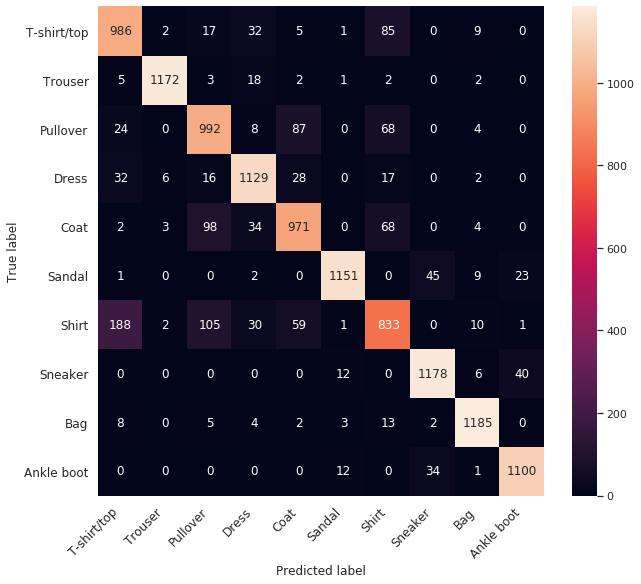

In [60]:
Y_val_95var_pred = train_pca_model(model_95var, pca_95var)

### 2.3. 90% explained variance

In [61]:
model_90var, pca_90var = build_pca_model(min_explained_variance=0.90, model_name="MLP_90var")

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

84 principal components → 0.9006989598274231 explained variance
84 / 784 = 10.71% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 29us/sample - loss: 0.8263 - accuracy: 0.7246 - val_loss: 0.4848 - val_accuracy: 0.8357
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4406 - accuracy: 0.8497 - val_loss: 0.4193 - val_accuracy: 0.8566
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3912 - accuracy: 0.8659 - val_loss: 0.3941 - val_accuracy: 0.8676
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3631 - accuracy: 0.8764 - val_loss: 0.3770 - val_accuracy: 0.8722
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3439 - accuracy: 0.8834 - val_loss: 0.3717 - val_accuracy: 0.8748
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3282 - accuracy: 0.8884 - val_loss: 0.3544 - val_accuracy: 0.8784
Epoch 7/64
48000/48000 [===========

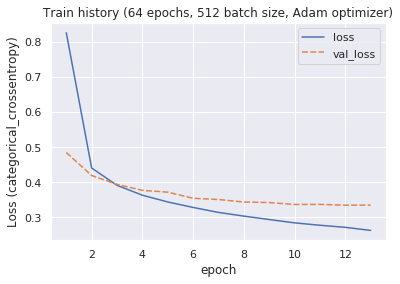

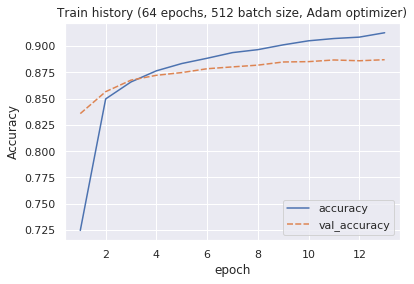

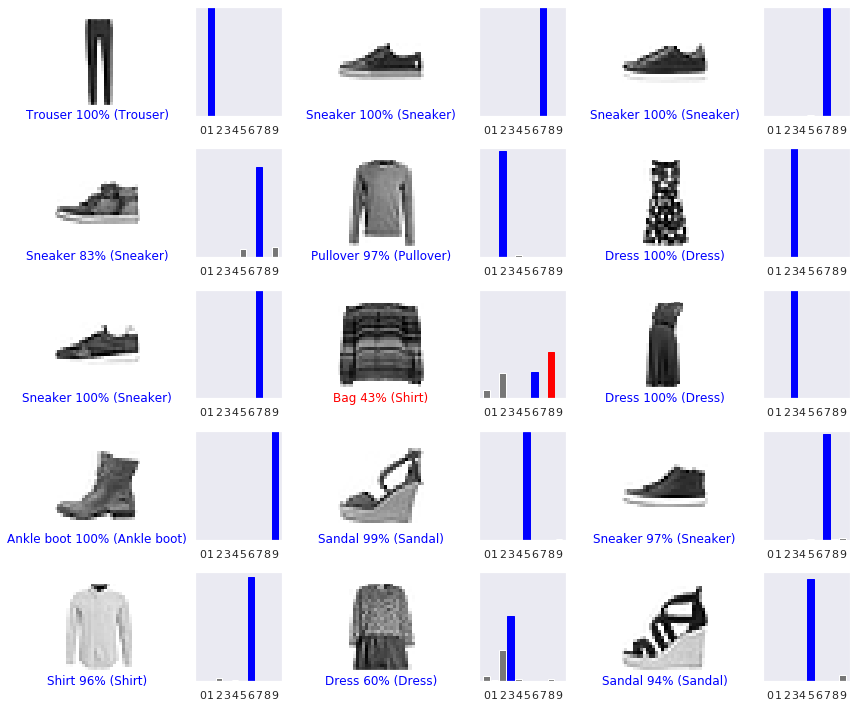

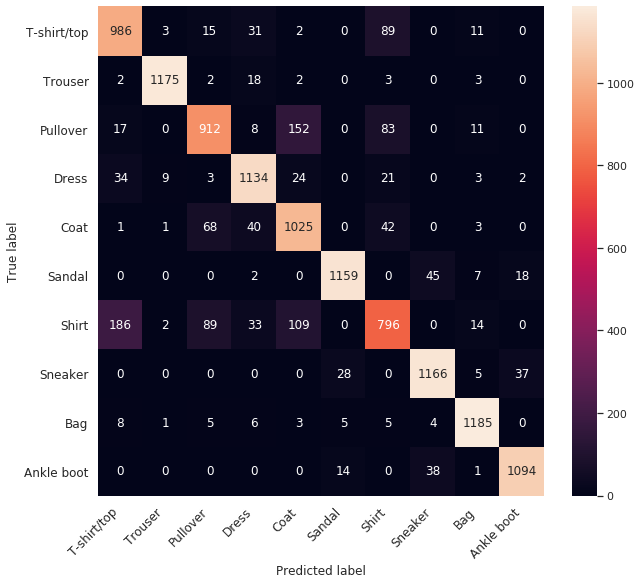

In [62]:
Y_val_90var_pred = train_pca_model(model_90var, pca_90var)

### 2.4. F1-scores

In [0]:
from sklearn.metrics import precision_recall_fscore_support

In [0]:
def print_f1_scores(ys, ys_pred, class_name_dict=CLASS_NAME):
    # ref.: https://github.com/erikperillo/ml-2sem2019/
    def harmonic_mean_of_positive_values(values, eps=1e-18):
        return len(values) / sum(1 / max(v, eps) for v in values)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(ys, ys_pred)
    print("                       Precision    Recall    F1-score")
    for i, (p, r, f1) in enumerate(zip(precision, recall, f1_score)):
        print(f"Class {i} {f'({class_name_dict[i]}):':<16} {p:.4f}  |  {r:.4f}  |  {f1:.4f}")
    print()
    print(f"Combined F1 score:  {harmonic_mean_of_positive_values(f1_score):.4f}")
    print(f"Combined Precision: {harmonic_mean_of_positive_values(precision):.4f}")
    print(f"Combined Recall:    {harmonic_mean_of_positive_values(recall):.4f}")

In [65]:
# MLP baseline
print_f1_scores(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8109  |  0.8373  |  0.8239
Class 1 (Trouser):       0.9915  |  0.9718  |  0.9816
Class 2 (Pullover):      0.7969  |  0.8191  |  0.8078
Class 3 (Dress):         0.9119  |  0.8748  |  0.8929
Class 4 (Coat):          0.7919  |  0.8483  |  0.8191
Class 5 (Sandal):        0.9741  |  0.9472  |  0.9605
Class 6 (Shirt):         0.7259  |  0.6981  |  0.7117
Class 7 (Sneaker):       0.9361  |  0.9482  |  0.9421
Class 8 (Bag):           0.9831  |  0.9517  |  0.9672
Class 9 (Ankle boot):    0.9436  |  0.9634  |  0.9534

Combined F1 score:  0.8771
Combined Precision: 0.8768
Combined Recall:    0.8774


In [66]:
# CNN baseline
print_f1_scores(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8512  |  0.8602  |  0.8556
Class 1 (Trouser):       0.9925  |  0.9876  |  0.9900
Class 2 (Pullover):      0.8976  |  0.8301  |  0.8625
Class 3 (Dress):         0.9191  |  0.9236  |  0.9213
Class 4 (Coat):          0.8462  |  0.8669  |  0.8564
Class 5 (Sandal):        0.9868  |  0.9732  |  0.9800
Class 6 (Shirt):         0.7393  |  0.7730  |  0.7558
Class 7 (Sneaker):       0.9380  |  0.9798  |  0.9584
Class 8 (Bag):           0.9836  |  0.9795  |  0.9815
Class 9 (Ankle boot):    0.9828  |  0.9477  |  0.9649

Combined F1 score:  0.9063
Combined Precision: 0.9064
Combined Recall:    0.9063


In [67]:
# 99% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_99var_pred, axis=1), CLASS_NAME) # FIXME why is this worse than 95% ?

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7995  |  0.8417  |  0.8201
Class 1 (Trouser):       0.9840  |  0.9726  |  0.9783
Class 2 (Pullover):      0.7920  |  0.8081  |  0.8000
Class 3 (Dress):         0.8920  |  0.8935  |  0.8928
Class 4 (Coat):          0.8176  |  0.8017  |  0.8096
Class 5 (Sandal):        0.9645  |  0.9496  |  0.9570
Class 6 (Shirt):         0.7181  |  0.6965  |  0.7071
Class 7 (Sneaker):       0.9410  |  0.9426  |  0.9418
Class 8 (Bag):           0.9598  |  0.9566  |  0.9582
Class 9 (Ankle boot):    0.9498  |  0.9573  |  0.9535

Combined F1 score:  0.8726
Combined Precision: 0.8726
Combined Recall:    0.8726


In [68]:
# 95% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_95var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7913  |  0.8672  |  0.8275
Class 1 (Trouser):       0.9890  |  0.9726  |  0.9808
Class 2 (Pullover):      0.8026  |  0.8385  |  0.8202
Class 3 (Dress):         0.8982  |  0.9179  |  0.9079
Class 4 (Coat):          0.8414  |  0.8229  |  0.8320
Class 5 (Sandal):        0.9746  |  0.9350  |  0.9544
Class 6 (Shirt):         0.7670  |  0.6778  |  0.7197
Class 7 (Sneaker):       0.9357  |  0.9531  |  0.9443
Class 8 (Bag):           0.9619  |  0.9697  |  0.9658
Class 9 (Ankle boot):    0.9450  |  0.9590  |  0.9520

Combined F1 score:  0.8824
Combined Precision: 0.8835
Combined Recall:    0.8813


In [69]:
# 90% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_90var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7990  |  0.8672  |  0.8317
Class 1 (Trouser):       0.9866  |  0.9751  |  0.9808
Class 2 (Pullover):      0.8336  |  0.7709  |  0.8011
Class 3 (Dress):         0.8915  |  0.9220  |  0.9065
Class 4 (Coat):          0.7783  |  0.8686  |  0.8210
Class 5 (Sandal):        0.9610  |  0.9415  |  0.9512
Class 6 (Shirt):         0.7661  |  0.6477  |  0.7019
Class 7 (Sneaker):       0.9306  |  0.9434  |  0.9369
Class 8 (Bag):           0.9533  |  0.9697  |  0.9615
Class 9 (Ankle boot):    0.9505  |  0.9538  |  0.9521

Combined F1 score:  0.8753
Combined Precision: 0.8778
Combined Recall:    0.8728


### 2.4. <90% explained variance

### 2.4.1. 80% explained variance

In [70]:
model_80var, pca_80var = build_pca_model(min_explained_variance=0.80, model_name="MLP_80var")

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

24 principal components → 0.8008705377578735 explained variance
24 / 784 = 3.06% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 30us/sample - loss: 0.8804 - accuracy: 0.7125 - val_loss: 0.5514 - val_accuracy: 0.8035
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.5057 - accuracy: 0.8254 - val_loss: 0.4797 - val_accuracy: 0.8357
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4593 - accuracy: 0.8425 - val_loss: 0.4557 - val_accuracy: 0.8459
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4356 - accuracy: 0.8505 - val_loss: 0.4435 - val_accuracy: 0.8436
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4209 - accuracy: 0.8558 - val_loss: 0.4272 - val_accuracy: 0.8525
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4045 - accuracy: 0.8604 - val_loss: 0.4217 - val_accuracy: 0.8543
Epoch 7/64
48000/48000 [===========

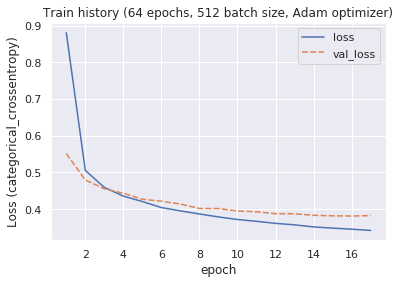

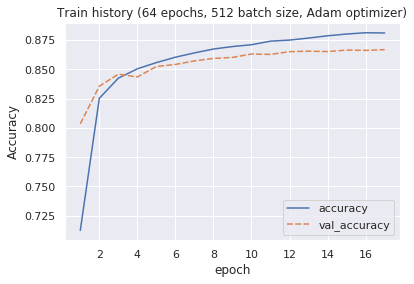

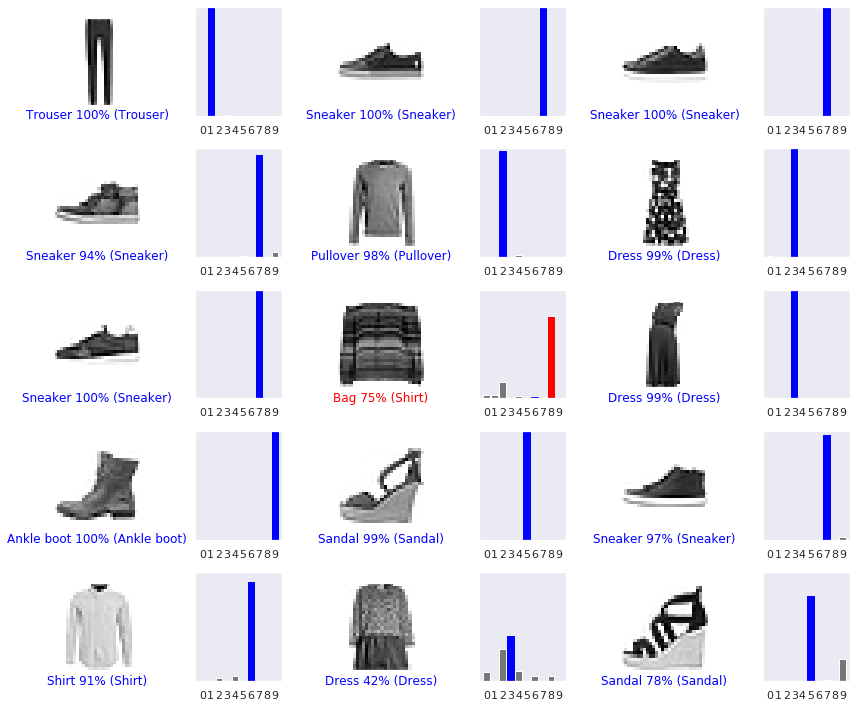

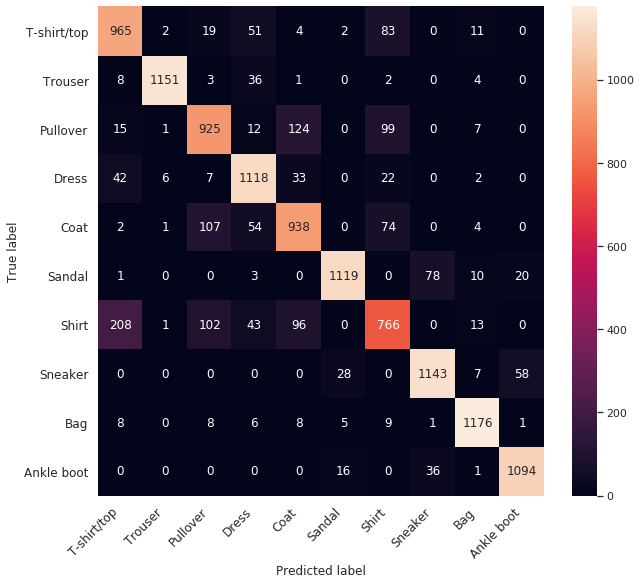

In [71]:
Y_val_80var_pred = train_pca_model(model_80var, pca_80var)

In [72]:
print_f1_scores(ys_val, np.argmax(Y_val_80var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7726  |  0.8487  |  0.8089
Class 1 (Trouser):       0.9905  |  0.9552  |  0.9725
Class 2 (Pullover):      0.7899  |  0.7819  |  0.7859
Class 3 (Dress):         0.8450  |  0.9089  |  0.8758
Class 4 (Coat):          0.7791  |  0.7949  |  0.7869
Class 5 (Sandal):        0.9564  |  0.9090  |  0.9321
Class 6 (Shirt):         0.7261  |  0.6233  |  0.6708
Class 7 (Sneaker):       0.9086  |  0.9248  |  0.9166
Class 8 (Bag):           0.9522  |  0.9624  |  0.9573
Class 9 (Ankle boot):    0.9327  |  0.9538  |  0.9431

Combined F1 score:  0.8540
Combined Precision: 0.8560
Combined Recall:    0.8521


### 2.4.2. 60% explained variance

In [73]:
model_60var, pca_60var = build_pca_model(min_explained_variance=0.60, model_name="MLP_60var")

PCA(copy=True, iterated_power='auto', n_components=0.6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

5 principal components → 0.6156876087188721 explained variance
5 / 784 = 0.64% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 30us/sample - loss: 1.0572 - accuracy: 0.6280 - val_loss: 0.7994 - val_accuracy: 0.6998
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7651 - accuracy: 0.7111 - val_loss: 0.7483 - val_accuracy: 0.7074
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7327 - accuracy: 0.7207 - val_loss: 0.7217 - val_accuracy: 0.7239
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7154 - accuracy: 0.7263 - val_loss: 0.7104 - val_accuracy: 0.7309
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7031 - accuracy: 0.7318 - val_loss: 0.6982 - val_accuracy: 0.7360
Epoch 6/64
48000/48000 [==============================] - 0s 9us/sample - loss: 0.6927 - accuracy: 0.7352 - val_loss: 0.6996 - val_accuracy: 0.7322
Epoch 7/64
48000/48000 [============

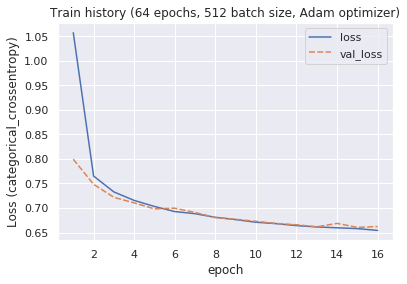

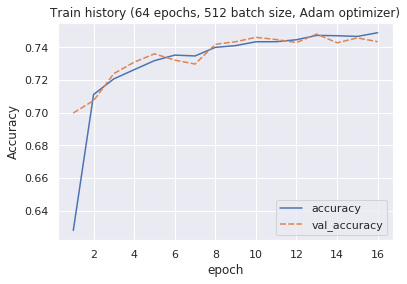

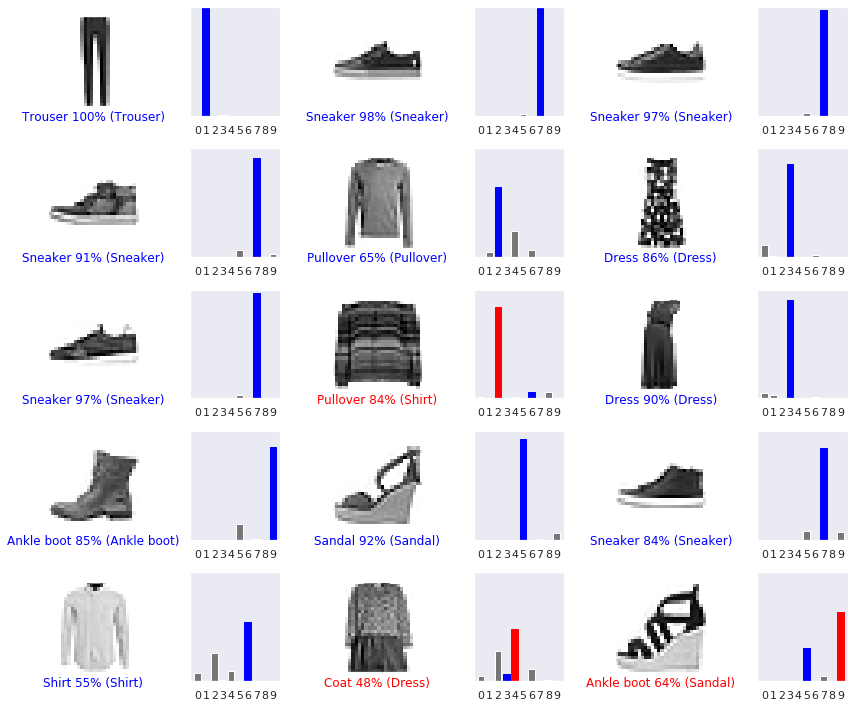

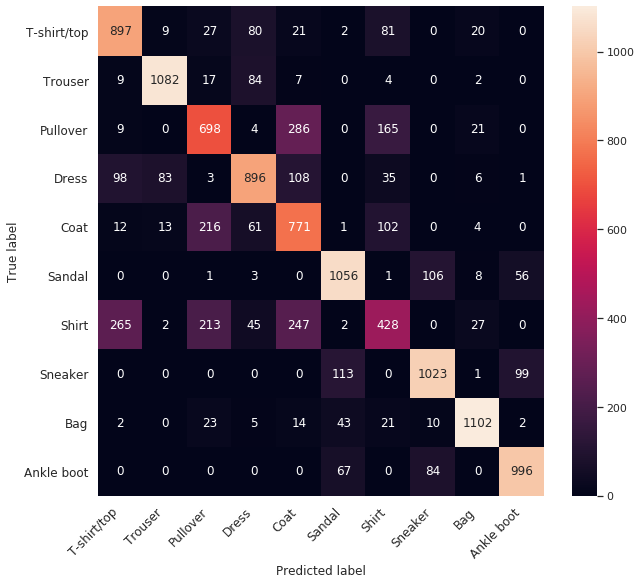

In [74]:
Y_val_60var_pred = train_pca_model(model_60var, pca_60var)

In [75]:
# 60% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_60var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.6943  |  0.7889  |  0.7386
Class 1 (Trouser):       0.9100  |  0.8979  |  0.9039
Class 2 (Pullover):      0.5826  |  0.5900  |  0.5863
Class 3 (Dress):         0.7606  |  0.7285  |  0.7442
Class 4 (Coat):          0.5303  |  0.6534  |  0.5854
Class 5 (Sandal):        0.8224  |  0.8578  |  0.8398
Class 6 (Shirt):         0.5114  |  0.3483  |  0.4143
Class 7 (Sneaker):       0.8365  |  0.8277  |  0.8320
Class 8 (Bag):           0.9253  |  0.9018  |  0.9134
Class 9 (Ankle boot):    0.8631  |  0.8684  |  0.8657

Combined F1 score:  0.7006
Combined Precision: 0.7111
Combined Recall:    0.6904


### 2.5. Plot the first principal components

Out of curiosity, let's visualize the first 2 and 3 components.

In [0]:
pca_3pc = PCA(n_components=3)

In [0]:
pca_3pc_result = pca_3pc.fit_transform(X_train)

In [78]:
print(f"Explained variance per principal component:")
for i, (var, cumsum) in enumerate(zip(pca_3pc.explained_variance_ratio_, np.cumsum(pca_3pc.explained_variance_ratio_))):
    print(f"PC {i+1}: {var:.4f} (cumulative sum: {cumsum:.2f})")

Explained variance per principal component:
PC 1: 0.2896 (cumulative sum: 0.29)
PC 2: 0.1775 (cumulative sum: 0.47)
PC 3: 0.0606 (cumulative sum: 0.53)


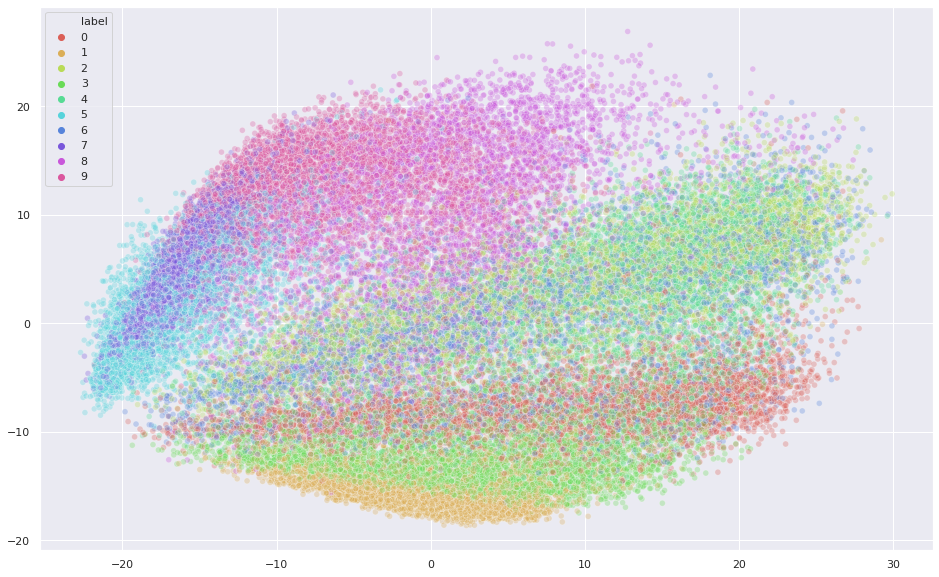

In [79]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=pca_3pc_result[..., 0], # PC 1
    y=pca_3pc_result[..., 1], # PC 2
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=train_dataset,
    legend="full",
    alpha=0.3
)

In [0]:
from mpl_toolkits.mplot3d import Axes3D

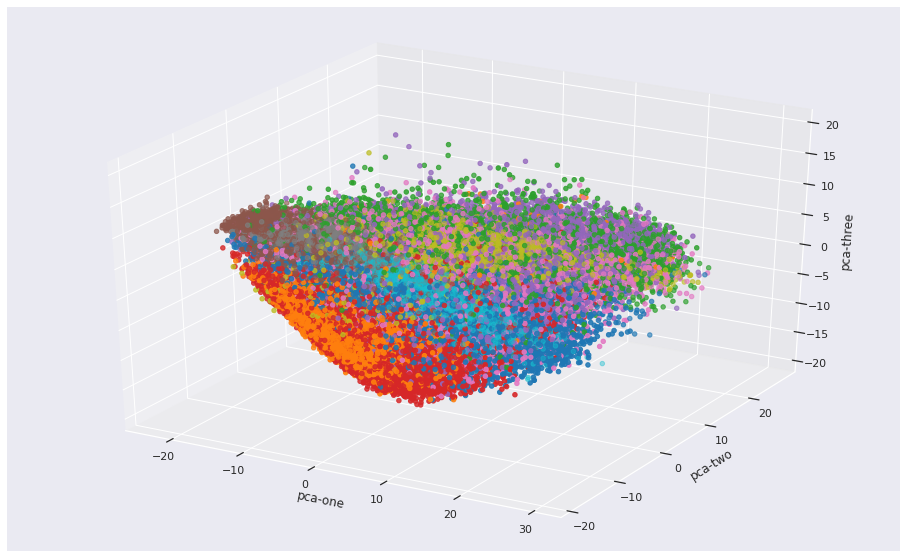

In [81]:
# run '%matplotlib notebook' for an interactive (but laggy) visualization
ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
ax.scatter(
    xs=pca_3pc_result[..., 0], # PC 1
    ys=pca_3pc_result[..., 1], # PC 2
    zs=pca_3pc_result[..., 2], # PC 3
    c=ys_train, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## 3. Using Autoencoders
Re-do the ﬁrst experiment considering Autoencoders for reducing the image dimensionality. Consider two diﬀerent latent vector size for reducing the image dimensionality. What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

Autoencoders are a branch of neural network which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over a number of iterations using gradient descent, minimizing the mean squared error. The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can now be treated as a variable in the same way each chosen principal component is used as a variable in following models.


In [0]:
from tensorflow.keras import Model
# ref.: https://blog.keras.io/building-autoencoders-in-keras.html
#       https://www.tensorflow.org/tutorials/generative/cvae

In [0]:
def build_autoencoder(latent_dim):
    __input   = Input(shape=(784,)) # 28 * 28 = 784 pixels
    __encoded = Dense(latent_dim, activation='relu', activity_regularizer=l1(1e-4))(__input)
    __decoded = Dense(784, activation='sigmoid')(__encoded)

    autoencoder = Model(__input, __decoded)
    print("\nAutoencoder summary:")
    print(autoencoder.summary())

    encoder = Model(__input, __encoded)
    print("\nEncoder summary:")
    print(encoder.summary())

    # create a placeholder for an encoded (24-dimensional) input
    encoded_input = Input(shape=(latent_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]

    decoder = Model(encoded_input, decoder_layer(encoded_input))
    print("\nDecoder summary:")
    print(decoder.summary())

    autoencoder.compile(optimizer='adam', loss='mse')

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.003, patience=3)]

    autoencoder.fit(X_train, X_train,
                    validation_data=(X_val, X_val),
                    epochs=MAX_EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    callbacks=callbacks,
                    verbose=TF_VERBOSE)
    return autoencoder, encoder, decoder

In [0]:
def show_autoencoder_samples(encoder, decoder):
    encoded_imgs = encoder.predict(X_val)
    decoded_imgs = decoder.predict(encoded_imgs)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_val[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [0]:
def train_ae_model(encoder, latent_dim, model_name):
    model = keras.Sequential([
        Input(shape=(latent_dim, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)

    model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    history_ae, best_model_ae = train(model, 
                                      encoder.predict(X_train), Y_train, 
                                      encoder.predict(X_val), Y_val)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_ae_pred = best_model_ae.predict(encoder.predict(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_ae_pred)

    print_cm(ys_val, np.argmax(Y_val_ae_pred, axis=1), CLASS_NAME)
    
    return Y_val_ae_pred, best_model_ae

### 3.1. Latent vector size of 84

In [0]:
latent_dim = 84

In [87]:
autoencoder_84, encoder_84, decoder_84 = build_autoencoder(latent_dim)


Autoencoder summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 84)                65940     
_________________________________________________________________
dense_20 (Dense)             (None, 784)               66640     
Total params: 132,580
Trainable params: 132,580
Non-trainable params: 0
_________________________________________________________________
None

Encoder summary:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 84)                6594

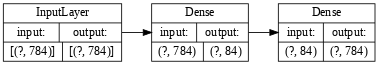

In [88]:
tf.keras.utils.plot_model(autoencoder_84, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

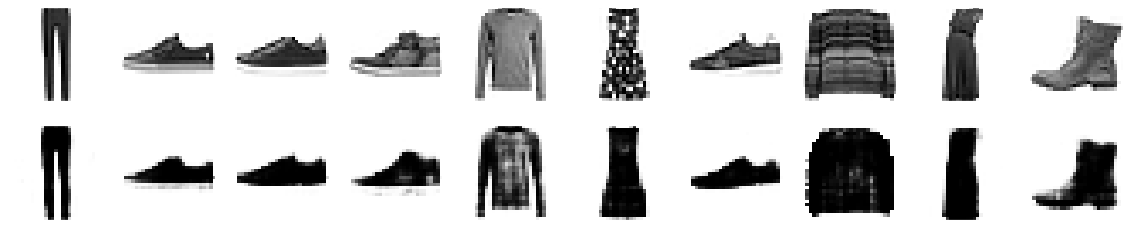

In [89]:
show_autoencoder_samples(encoder_84, decoder_84)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 22us/sample - loss: 0.9979 - accuracy: 0.6787 - val_loss: 0.5328 - val_accuracy: 0.8107
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4822 - accuracy: 0.8321 - val_loss: 0.4595 - val_accuracy: 0.8385
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4320 - accuracy: 0.8500 - val_loss: 0.4313 - val_accuracy: 0.8497
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4043 - accuracy: 0.8609 - val_loss: 0.4094 - val_accuracy: 0.8566
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3843 - accuracy: 0.8670 - val_loss: 0.4017 - val_accuracy: 0.8625
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3695 - accuracy: 0.8720 - val_loss: 0.3921 - val_accuracy: 0.8644
Epoch 7/64
48000/48000 [===========

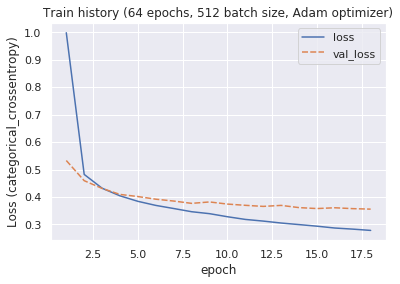

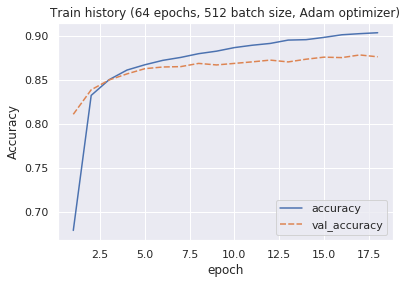

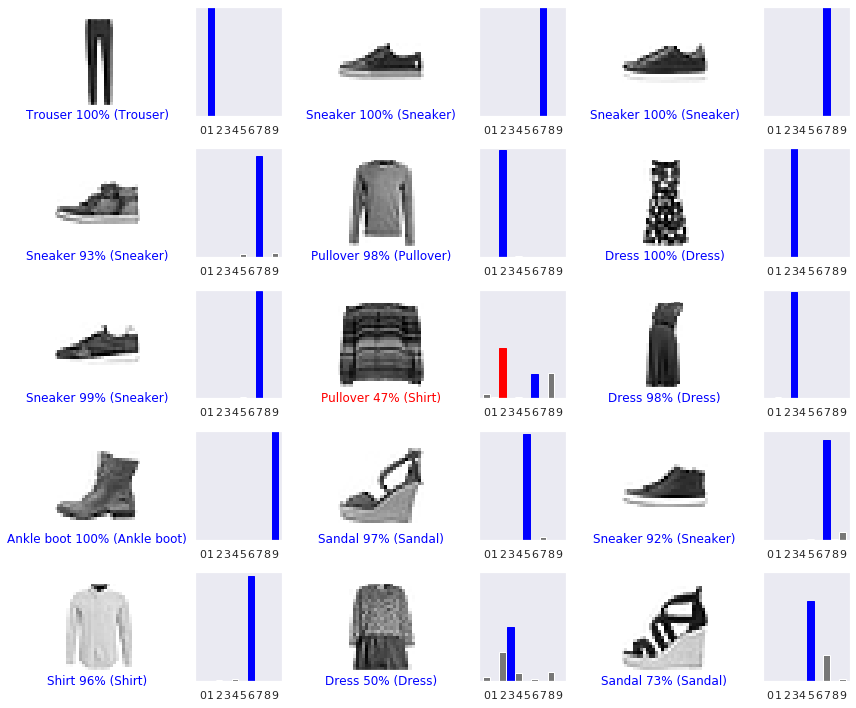

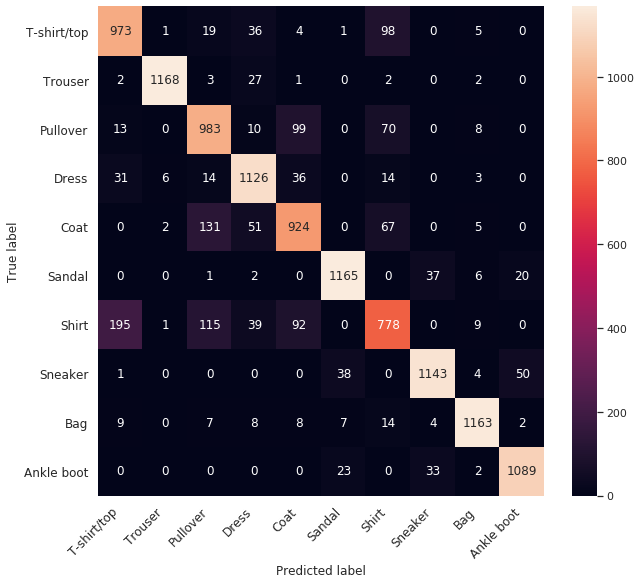

In [90]:
Y_val_ae_84_pred, model_ae_84 = train_ae_model(encoder_84, latent_dim, model_name="AE_84")

In [91]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_84_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7949  |  0.8558  |  0.8242
Class 1 (Trouser):       0.9915  |  0.9693  |  0.9803
Class 2 (Pullover):      0.7722  |  0.8309  |  0.8005
Class 3 (Dress):         0.8668  |  0.9154  |  0.8905
Class 4 (Coat):          0.7938  |  0.7831  |  0.7884
Class 5 (Sandal):        0.9441  |  0.9464  |  0.9452
Class 6 (Shirt):         0.7459  |  0.6330  |  0.6849
Class 7 (Sneaker):       0.9392  |  0.9248  |  0.9319
Class 8 (Bag):           0.9635  |  0.9517  |  0.9576
Class 9 (Ankle boot):    0.9380  |  0.9494  |  0.9437

Combined F1 score:  0.8644
Combined Precision: 0.8663
Combined Recall:    0.8625


### 3.2. Latent vector size of 24

In [0]:
latent_dim = 24

In [93]:
autoencoder_24, encoder_24, decoder_24 = build_autoencoder(latent_dim)


Autoencoder summary:
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 24)                18840     
_________________________________________________________________
dense_25 (Dense)             (None, 784)               19600     
Total params: 38,440
Trainable params: 38,440
Non-trainable params: 0
_________________________________________________________________
None

Encoder summary:
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 24)                1884

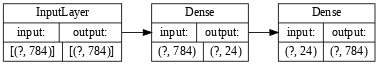

In [94]:
tf.keras.utils.plot_model(autoencoder_24, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

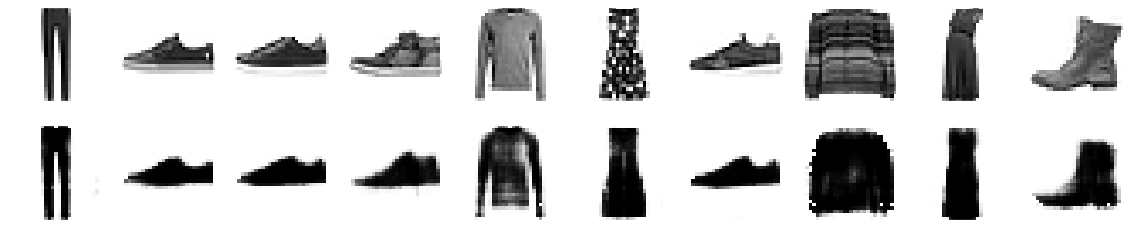

In [95]:
show_autoencoder_samples(encoder_24, decoder_24)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 22us/sample - loss: 1.1362 - accuracy: 0.6588 - val_loss: 0.5933 - val_accuracy: 0.7951
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.5470 - accuracy: 0.8112 - val_loss: 0.5138 - val_accuracy: 0.8182
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4957 - accuracy: 0.8287 - val_loss: 0.4831 - val_accuracy: 0.8288
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4682 - accuracy: 0.8380 - val_loss: 0.4716 - val_accuracy: 0.8325
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4504 - accuracy: 0.8440 - val_loss: 0.4562 - val_accuracy: 0.8375
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4386 - accuracy: 0.8476 - val_loss: 0.4503 - val_accuracy: 0.8393
Epoch 7/64
48000/48000 [===========

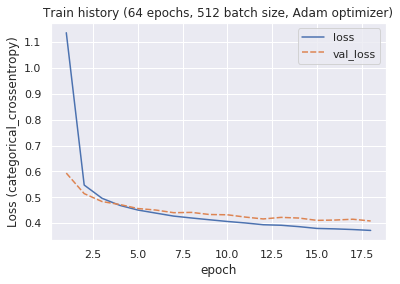

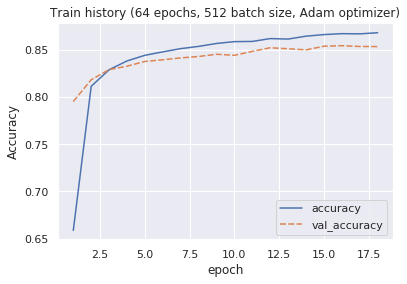

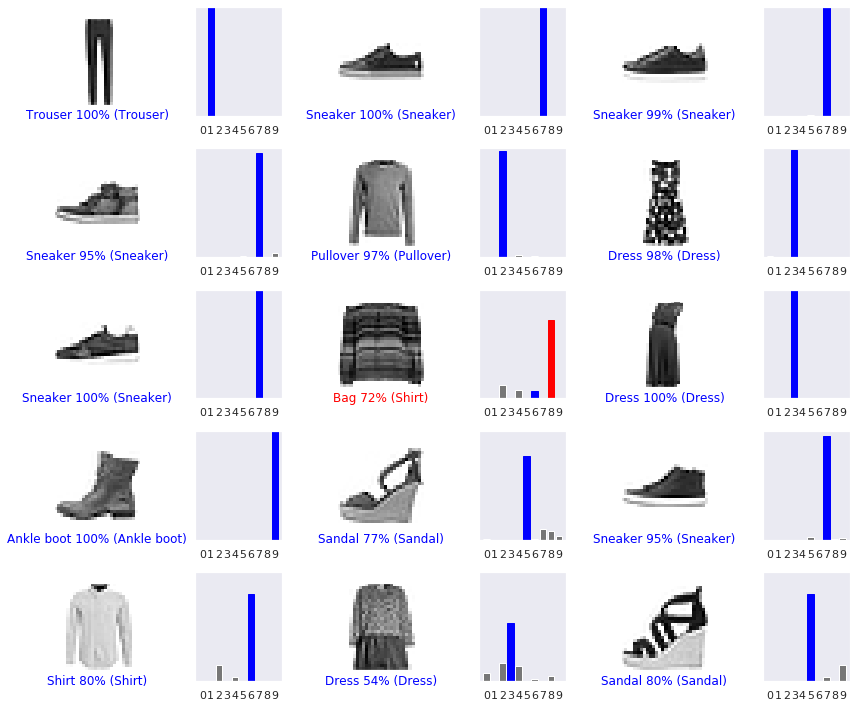

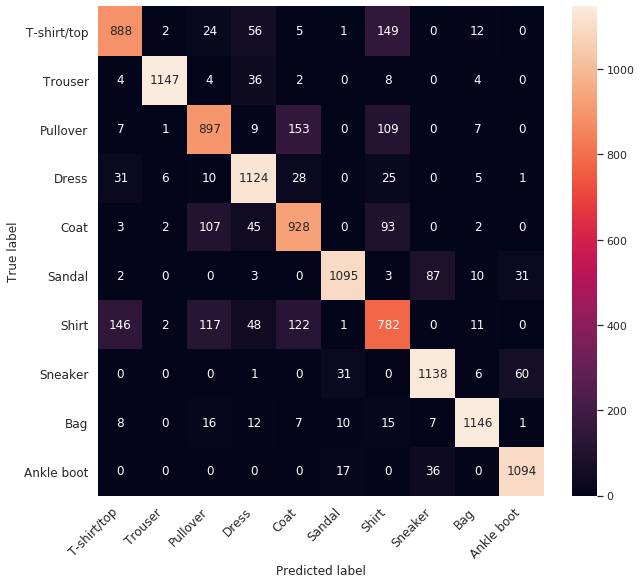

In [96]:
Y_val_ae_24_pred, model_ae_24 = train_ae_model(encoder_24, latent_dim, model_name="AE_24")

In [97]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_24_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8154  |  0.7810  |  0.7978
Class 1 (Trouser):       0.9888  |  0.9519  |  0.9700
Class 2 (Pullover):      0.7634  |  0.7582  |  0.7608
Class 3 (Dress):         0.8426  |  0.9138  |  0.8768
Class 4 (Coat):          0.7454  |  0.7864  |  0.7654
Class 5 (Sandal):        0.9481  |  0.8895  |  0.9179
Class 6 (Shirt):         0.6605  |  0.6363  |  0.6482
Class 7 (Sneaker):       0.8975  |  0.9207  |  0.9089
Class 8 (Bag):           0.9526  |  0.9378  |  0.9452
Class 9 (Ankle boot):    0.9217  |  0.9538  |  0.9374

Combined F1 score:  0.8401
Combined Precision: 0.8408
Combined Recall:    0.8395


## 4. Using clustering techniques
Explore two clustering algorithms using the reduced features (PCA or Autoencoders). Do the clusters make sense? Check the validity/quality of your clusters.

In [0]:
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, v_measure_score # require ground-truth label knowledge
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [0]:
def show_clusters(clusters, data):
    # [-1.0, 1.0], with 1.0 being the perfect score, and 0.0 being random
    print(f"Adjusted Rand Score:     {adjusted_rand_score(labels_true=ys_val, labels_pred=clusters.labels_):.4f}")
    # [0.0, 1.0], harmonic mean between homogeneity and completeness scores (higher is better)
    print(f"V-measure Score:         {v_measure_score(labels_true=ys_val, labels_pred=clusters.labels_):.4f}")
    # [-1.0, 1.0], with 1.0 for highly dense clustering, 0.0 indicate overlapping clusters, and -1.0 for incorrect clustering
    print(f"Silhouette Coefficient:  {silhouette_score(X=data, labels=clusters.labels_):.4f}")
    # the score is higher when clusters are dense and well separated
    print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X=data, labels=clusters.labels_):.1f}")
    # 0.0 is the lowest possible score, with values closer to it indicating a better partition
    print(f"Davies-Bouldin Index:    {davies_bouldin_score(X=data, labels=clusters.labels_):.4f}")

    labels = clusters.labels_.astype(float)
    # we select the first two feature columns for plotting in 2D
    __xs, __ys = data[..., 0], data[..., 1]

    try:
        centroids = clusters.cluster_centers_ # K-Means and Mini-Batch K-Means
        __xc, __yc = centroids[..., 0], centroids[..., 1]
    except:
        centroids = None
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=__xs, y=__ys, 
                    hue=labels, palette=sns.color_palette("hls", 10), alpha=0.3)
    if centroids is not None:
        sns.scatterplot(x=__xc, y=__yc, 
                        marker='+', s=175, linewidths=3, color='black', zorder=10)
    plt.show()

Let's standardize the features we'll be using for clustering with Z-score:

In [110]:
reduced_features_list = [("X_val_80var", pca_80var.transform(X_val)), ("X_val_90var", pca_90var.transform(X_val))]
                      # [("X_val_ae_24", encoder_24.predict(X_val)), ("X_val_ae_84", encoder_84.predict(X_val))]
reduced_features_zscore = []
for name, reduced_features in reduced_features_list:
    print(f"{name+':':<19} {str(reduced_features.shape):<11} "
          f"| min: {reduced_features.min():>6.2f} | max: {reduced_features.max():>6.2f} "
          f"| mean: {reduced_features.mean():>6.3f} | std: {reduced_features.std():>6.3f}")
    reduced_features_zscore.append((name + "_zscore", (reduced_features - reduced_features.mean()) / reduced_features.std()))
for name, reduced_features in reduced_features_zscore:
    print(f"{name+':':<19} {str(reduced_features.shape):<11} "
          f"| min: {reduced_features.min():>6.2f} | max: {reduced_features.max():>6.2f} "
          f"| mean: {reduced_features.mean():>6.3f} | std: {reduced_features.std():>6.3f}")

X_val_80var:        (12000, 24) | min: -22.32 | max:  30.72 | mean: -0.003 | std:  4.271
X_val_90var:        (12000, 84) | min: -22.32 | max:  30.72 | mean: -0.001 | std:  2.421
X_val_80var_zscore: (12000, 24) | min:  -5.23 | max:   7.19 | mean:  0.000 | std:  1.000
X_val_90var_zscore: (12000, 84) | min:  -9.22 | max:  12.69 | mean:  0.000 | std:  1.000


In [0]:
X_val_80var_zscore, X_val_90var_zscore = reduced_features_zscore[0][1], reduced_features_zscore[1][1]

## 4.1. K-Means

### 4.1.1. PCA reduced features (90% explained variance, 84 principal components)

Adjusted Rand Score:     0.3465
V-measure Score:         0.5100
Silhouette Coefficient:  0.1871
Calinski-Harabasz Index: 1952.6
Davies-Bouldin Index:    1.5694


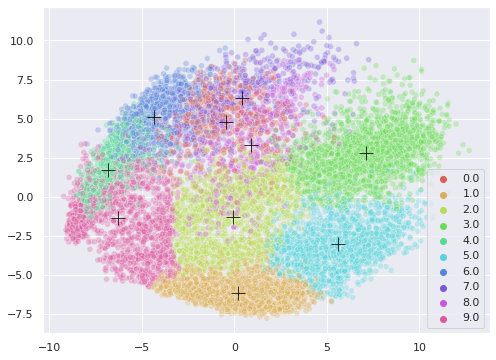

In [112]:
kmeans_pca_90var = KMeans(n_clusters=10).fit(X_val_90var_zscore)
show_clusters(kmeans_pca_90var, X_val_90var_zscore)

### 4.1.2. PCA reduced features (80% explained variance, 24 principal components)

Adjusted Rand Score:     0.3460
V-measure Score:         0.5092
Silhouette Coefficient:  0.2365
Calinski-Harabasz Index: 2669.1
Davies-Bouldin Index:    1.3295


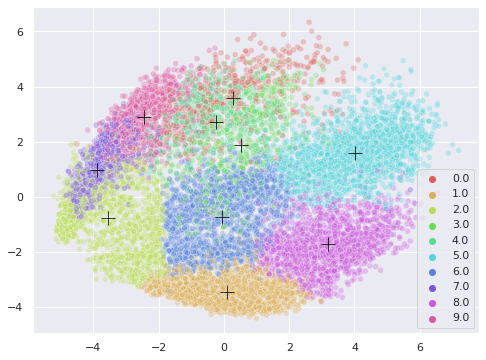

In [113]:
kmeans_pca_80var = KMeans(n_clusters=10).fit(X_val_80var_zscore)
show_clusters(kmeans_pca_80var, X_val_80var_zscore)

## 4.2. Mini-Batch K-Means

### 4.2.1. PCA reduced features (90% explained variance, 84 principal components)

Adjusted Rand Score:     0.3376
V-measure Score:         0.4896
Silhouette Coefficient:  0.1643
Calinski-Harabasz Index: 1914.0
Davies-Bouldin Index:    1.7796


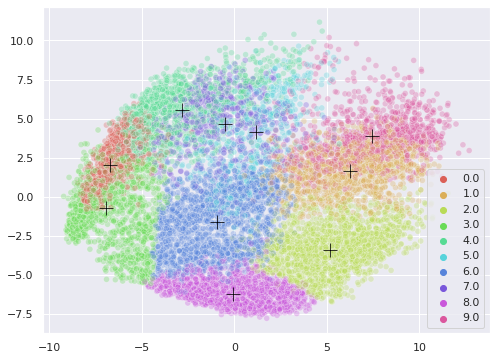

In [114]:
mbkmeans_pca_90var = MiniBatchKMeans(n_clusters=10).fit(X_val_90var_zscore)
show_clusters(mbkmeans_pca_90var, X_val_90var_zscore)

### 4.2.2. PCA reduced features (80% explained variance, 24 principal components)

Adjusted Rand Score:     0.3757
V-measure Score:         0.5195
Silhouette Coefficient:  0.2181
Calinski-Harabasz Index: 2521.8
Davies-Bouldin Index:    1.5397


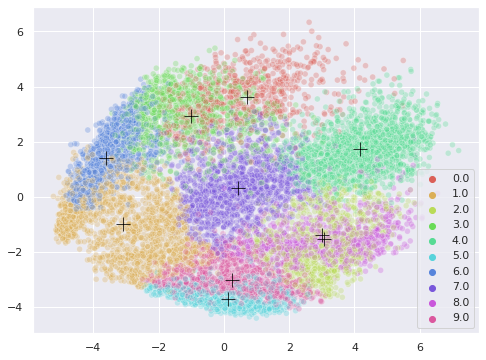

In [115]:
mbkmeans_pca_80var = MiniBatchKMeans(n_clusters=10).fit(X_val_80var_zscore)
show_clusters(mbkmeans_pca_80var, X_val_80var_zscore)

## 4.3. Agglomerative clustering

### 4.3.1. PCA reduced features (90% explained variance, 84 principal components)

Adjusted Rand Score:     0.3420
V-measure Score:         0.4995
Silhouette Coefficient:  0.1476
Calinski-Harabasz Index: 1649.8
Davies-Bouldin Index:    1.8602


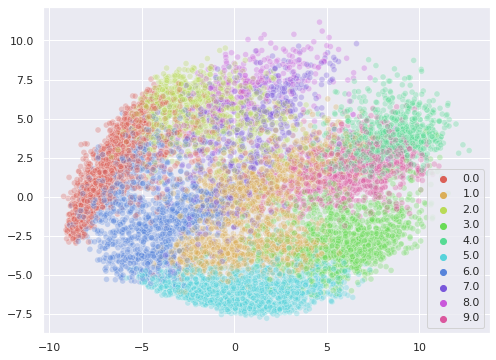

In [116]:
agglomerative_pca_90var = AgglomerativeClustering(n_clusters=10).fit(X_val_90var_zscore)
show_clusters(agglomerative_pca_90var, X_val_90var_zscore)

### 4.3.2. PCA reduced features (80% explained variance, 24 principal components)

Adjusted Rand Score:     0.3830
V-measure Score:         0.5481
Silhouette Coefficient:  0.1835
Calinski-Harabasz Index: 2253.7
Davies-Bouldin Index:    1.5920


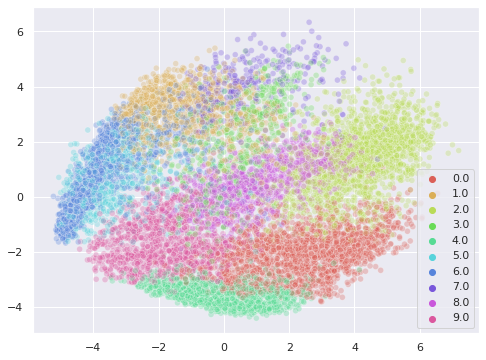

In [117]:
agglomerative_pca_80var = AgglomerativeClustering(n_clusters=10).fit(X_val_80var_zscore)
show_clusters(agglomerative_pca_80var, X_val_80var_zscore)

## 5. Running the test set on our best model
Since our best network was the baseline CNN (considering both validation accuracy and combined F1 score), let's at last try it out on the Fashion MNIST test set.

In [121]:
# NOTE we are using the mean and std values from the training data to normalize the test set

X_test = (xs_test - mean) / std
print(f"xs_test: mean={xs_test.mean():>8.4f}, stddev={xs_test.std():>7.4f}")
print(f"X_test:  mean={X_test.mean():>8.4f}, stddev={X_test.std():>7.4f}") # mean should (hopefully) be close to 0 and stddev close to 1

xs_test: mean=  0.2869, stddev= 0.3540
X_test:  mean=  0.0020, stddev= 1.0032


In [122]:
Y_test = onehot_encode(ys_test)
print(ys_test.shape, Y_test.shape)

(10000,) (10000, 10)


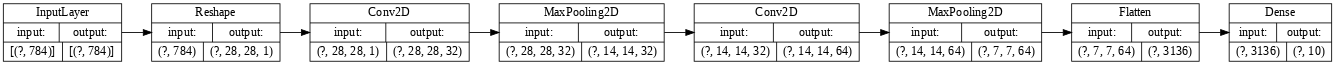

In [125]:
tf.keras.utils.plot_model(best_conv_model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

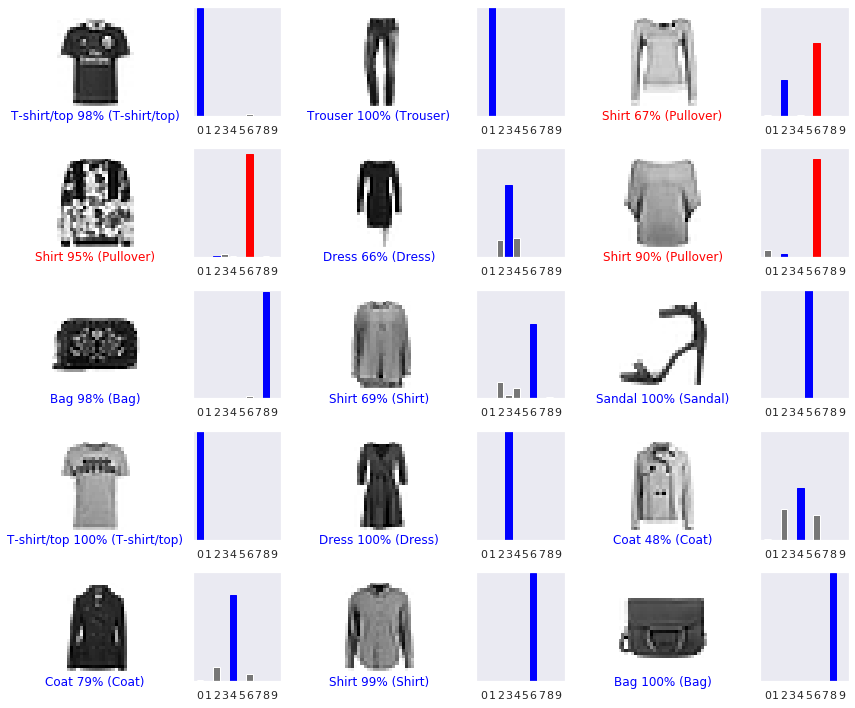

In [126]:
Y_test_pred = best_conv_model.predict(X_test)
plot_image_with_prediction(X_test, ys_test, Y_test_pred)

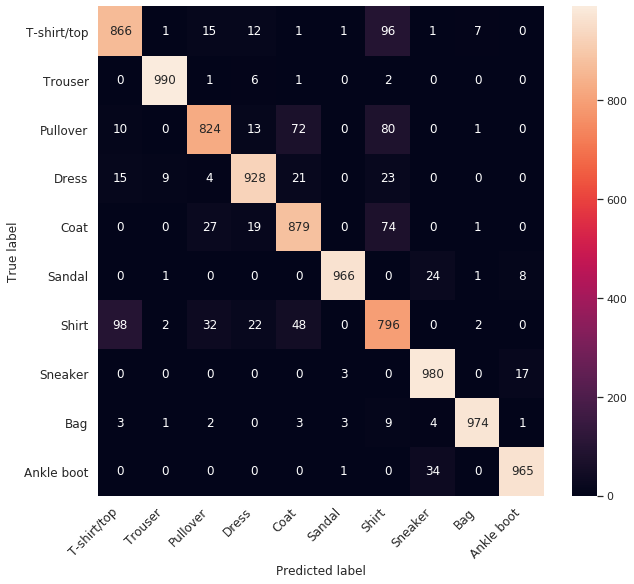

In [127]:
print_cm(ys_test, np.argmax(Y_test_pred, axis=1), CLASS_NAME)

In [128]:
print_f1_scores(ys_test, np.argmax(Y_test_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8730  |  0.8660  |  0.8695
Class 1 (Trouser):       0.9861  |  0.9900  |  0.9880
Class 2 (Pullover):      0.9105  |  0.8240  |  0.8651
Class 3 (Dress):         0.9280  |  0.9280  |  0.9280
Class 4 (Coat):          0.8576  |  0.8790  |  0.8681
Class 5 (Sandal):        0.9918  |  0.9660  |  0.9787
Class 6 (Shirt):         0.7370  |  0.7960  |  0.7654
Class 7 (Sneaker):       0.9396  |  0.9800  |  0.9594
Class 8 (Bag):           0.9878  |  0.9740  |  0.9809
Class 9 (Ankle boot):    0.9738  |  0.9650  |  0.9694

Combined F1 score:  0.9116
Combined Precision: 0.9116
Combined Recall:    0.9117


In [0]:
from sklearn.metrics import accuracy_score

In [131]:
print(f"Accuracy on the test set: {accuracy_score(ys_test, np.argmax(Y_test_pred, axis=1))}")

Accuracy on the test set: 0.9168


In [118]:
strftime('%X')

'20:16:26'